In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from lsc import LangevinSparseCoding
from utils import KLDivergence

In [96]:
n_features = 2
n_latent = 2
sparsity_penalty = 1.0
var = 1/sparsity_penalty
temperature = 1
dt = 1e-3
mass = 1
NOISE_MEAN, NOISE_STD = 0 , 0.1

C = lambda s: s.abs().sum(dim=1)
Cprime = lambda s: torch.sign(s)

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD
)

lsc.A = torch.tensor([[1., 1.], [1., -1.]])

n_samples = int(5e3)
distribution = torch.distributions.Laplace(0.0, var)
s_star = distribution.sample(sample_shape=[n_samples,n_latent])

x = (lsc.A@s_star.T).T + np.random.normal(NOISE_MEAN, NOISE_STD) # Additive Gaussian Noise

Text(0.5, 1.0, 'Sampled prior, $P(s)$; $n=5000$')

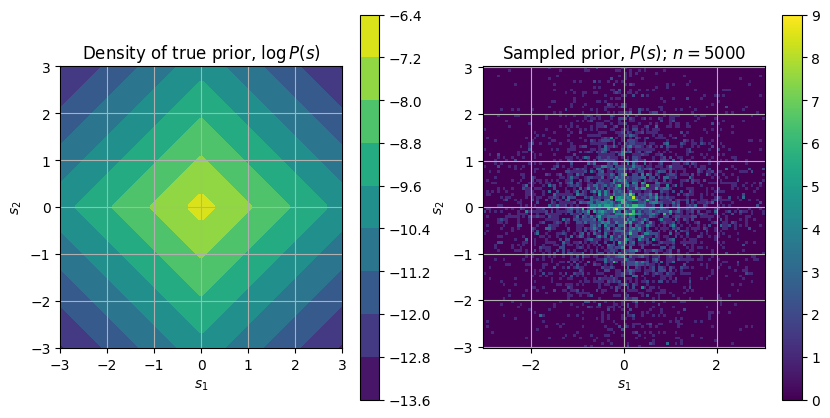

In [97]:
smax = 3
n_bins = 100

xlist = np.linspace(-smax, smax, n_bins)
ylist = np.linspace(-smax, smax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T
true_prior = np.exp(distribution.log_prob(torch.tensor(Sgrid)).data.numpy().sum(axis=1))
true_prior /= np.sum(true_prior)

sampled_prior, xedges, yedges = np.histogram2d(
    x=s_star[:,0].numpy(),
    y=s_star[:,1].numpy(),
    bins=n_bins,
    range=[[-smax, smax], [-smax, smax]],
    density=False,
)
sampled_prior = sampled_prior.T
# sampled_prior /= np.sum(sampled_prior)


fig,axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
cp = ax.contourf(X, Y, np.log(true_prior.reshape(X.shape)))#, vmax=pS_true_.max(),vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Density of true prior, $\log P(s)$')

ax = axs[1]
cp = ax.pcolormesh(X, Y,sampled_prior)#, vmax=pS_true_.max(),vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Sampled prior, $P(s)$; $n=%d$'%(n_samples))


In [98]:
def compute_2D_histogram(data,datamax=3,n_bins=100,normalize=True):
    """
    parameters
    ----------
    data : shape=[n_interations,n_data_points,2]

    returns
    -------
    all_dists : shape[n_data_points,n_bins,n_bins]
    """
    n_data_points = data.shape[1]
    xlist = np.linspace(-datamax, datamax, n_bins)
    ylist = np.linspace(-datamax, datamax, n_bins)
    X, Y = np.meshgrid(xlist, ylist)
    all_dists = np.empty([n_data_points,n_bins,n_bins])

    for i in (range(n_data_points)):
        # compute emperical pdf (second order)
        pS_emperical, xedges, yedges = np.histogram2d(
            x=data[:,i,0],
            y=data[:,i,1],
            bins=n_bins,
            range=[[-datamax, datamax], [-datamax, datamax]],
            density=False,
        )
        pS_emperical = pS_emperical.T
        if normalize:
            pS_emperical /= np.sum(pS_emperical)
        all_dists[i,:,:] = pS_emperical
    return all_dists

In [109]:
first_order_dt  = 1e-2
second_order_dt = 1e-3
mass = 1

first_order_lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=first_order_dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD
)

second_order_lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=second_order_dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD
)

first_order_lsc.A  = lsc.A
second_order_lsc.A = lsc.A

In [111]:
tmax = int(5e3)
kl_compute_interval = int(1e2)

v = torch.zeros_like(s_star) 
s_inference_second = torch.zeros_like(s_star)
s_inference_first = torch.zeros_like(s_star)

S_second = []
S_first = []
kl_vals_second = []
kl_vals_first = []
for n in tqdm(range(tmax)):
    # -- second order update --
    ds,dv = second_order_lsc.second_order_langevin_update(x,s_inference_second,v)
    s_inference_second += torch.clone(ds)
    v += torch.clone(dv)
    S_second.append(s_inference_second.data.numpy().copy())

    # -- first order update --
    s_inference_first += torch.clone(first_order_lsc.first_order_langevin_update(x,s_inference_first))
    S_first.append(s_inference_first.data.numpy().copy())

    if n%kl_compute_interval == 0:
        emp_prior_second = compute_2D_histogram(np.asarray(S_second))
        emp_prior_first = compute_2D_histogram(np.asarray(S_first))

        kl_second = KLDivergence(np.mean(emp_prior_second,axis=0).flatten(),true_prior.flatten())
        kl_first = KLDivergence(np.mean(emp_prior_first,axis=0).flatten(),true_prior.flatten())

        kl_vals_second.append(kl_second)
        kl_vals_first.append(kl_first)

S_second = np.asarray(S_second)
S_first = np.asarray(S_first)

emp_prior_second = compute_2D_histogram(S_second)
emp_prior_first = compute_2D_histogram(S_first)

kl_second = KLDivergence(np.mean(emp_prior_second,axis=0).flatten(),true_prior.flatten())
kl_first  = KLDivergence(np.mean( emp_prior_first,axis=0).flatten(),true_prior.flatten())

print('Final KL between first-order and true prior:  %.4f'%(kl_first))
print('Final KL between second-order and true prior: %.4f'%(kl_second))

100%|██████████| 5000/5000 [03:03<00:00, 27.22it/s]


Final KL between first-order and true prior:  0.0530
Final KL between second-order and true prior: 0.0586


Text(0.5, 1.0, 'Second order $\\log <P(s|x)>_x$')

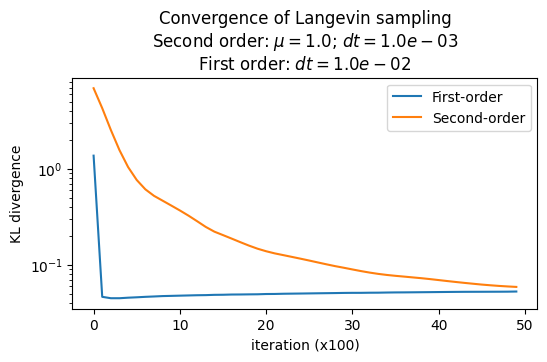

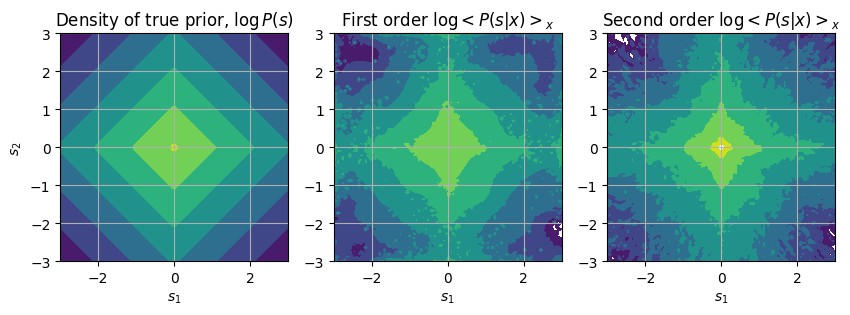

In [112]:
fig,ax = plt.subplots(figsize=(6,3))
ax.semilogy(kl_vals_first,label='First-order')
ax.semilogy(kl_vals_second,label='Second-order')
ax.set_xlabel('iteration (x%d)'%(kl_compute_interval))
ax.set_ylabel('KL divergence')
ax.set_title('Convergence of Langevin sampling\nSecond order: $\mu=%.1f$; $dt=%.1e$\nFirst order: $dt=%.1e$'%(second_order_lsc.mass,second_order_lsc.dt.item(),first_order_lsc.dt.item()))
ax.legend()

# ---- 
log_prob_lines = np.arange(-13,-5)

fig,axs = plt.subplots(1,3,figsize=(10,5))
axs = axs.flatten()
ax = axs[0]
cp = ax.contourf(X, Y, np.log(true_prior.reshape(X.shape)),log_prob_lines)
# fig.colorbar(cp) # Add a colorbar to a plot"
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Density of true prior, $\log P(s)$')

ax = axs[1]
cp = ax.contourf(X, Y, np.log(np.mean(emp_prior_first,axis=0)),log_prob_lines)
# fig.colorbar(cp) # Add a colorbar to a plot"
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
# ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'First order $\log <P(s|x)>_x$')

ax = axs[2]
cp = ax.contourf(X, Y, np.log(np.mean(emp_prior_second,axis=0)),log_prob_lines)
# fig.colorbar(cp,fraction=0.046, pad=0.04) # Add a colorbar to a plot"
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
# ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Second order $\log <P(s|x)>_x$')

In [117]:
tmax = int(5e3)
dts = dt_list = 10.**np.linspace(-7,-1,10)

kl_vals_second = []
kl_vals_first = []

for i in tqdm(range(len(dts))):
    # set dt
    first_order_lsc.set_dt(dts[i])
    second_order_lsc.set_dt(dts[i])

    v = torch.zeros_like(s_star) 
    s_inference_second = torch.zeros_like(s_star)
    s_inference_first = torch.zeros_like(s_star)

    S_second = []
    S_first = []
    for n in (range(tmax)):
        # -- second order update --
        ds,dv = second_order_lsc.second_order_langevin_update(x,s_inference_second,v)
        s_inference_second += torch.clone(ds)
        v += torch.clone(dv)
        S_second.append(s_inference_second.data.numpy().copy())

        # -- first order update --
        s_inference_first += torch.clone(first_order_lsc.first_order_langevin_update(x,s_inference_first))
        S_first.append(s_inference_first.data.numpy().copy())

    S_second = np.asarray(S_second)
    S_first = np.asarray(S_first)

    emp_prior_second = compute_2D_histogram(S_second)
    emp_prior_first = compute_2D_histogram(S_first)

    kl_second = KLDivergence(np.mean(emp_prior_second,axis=0).flatten(),true_prior.flatten())
    kl_first = KLDivergence(np.mean(emp_prior_first,axis=0).flatten(),true_prior.flatten())
    kl_vals_second.append(kl_second)
    kl_vals_first.append(kl_first)

    # print('Final KL between first-order and true prior:  %.4f'%(kl_first))
    # print('Final KL between second-order and true prior: %.4f'%(kl_second))

 80%|████████  | 8/10 [01:14<00:18,  9.11s/it]/var/folders/hy/7cxjc3qx1vsfk45ckcv7_w3h0000gn/T/ipykernel_48136/3946513506.py:28: RuntimeWarning: invalid value encountered in divide
  pS_emperical /= np.sum(pS_emperical)
100%|██████████| 10/10 [01:30<00:00,  9.09s/it]


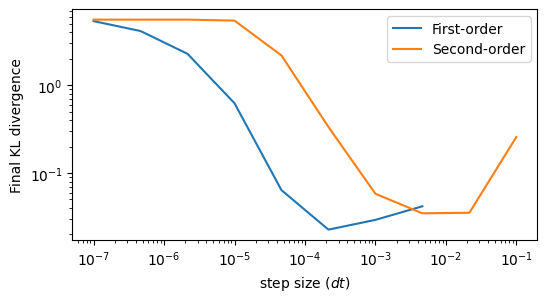

In [118]:
fig,ax = plt.subplots(figsize=(6,3))
ax.loglog(dts,kl_vals_first,label='First-order')
ax.loglog(dts,kl_vals_second,label='Second-order')
ax.set_xlabel('step size ($dt$)'%(dts))
ax.set_ylabel('Final KL divergence')
# ax.set_title('Convergence of Langevin sampling\nSecond order: $\mu=%.1f$; $dt=%.1e$\nFirst order: $dt=%.1e$'%(second_order_lsc.mass,second_order_lsc.dt.item(),first_order_lsc.dt.item()))
ax.legend()


 * Why does first order consistently achieve lower KL div? 
    * try different masses, maybe that is the issue? 

In [119]:
kl_vals_first

[5.351418544498126,
 4.129638398210771,
 2.2715598564293757,
 0.6226198592543571,
 0.06386173709670423,
 0.022710084177878252,
 0.029317939522946652,
 0.04186613053292781,
 nan,
 0.5482135156136232]

In [6]:
tmax = int(1e5)

s_inference = torch.ones_like(s_star) #Change to L0
v = torch.zeros_like(s_star) #Change to L0
# s_inference = th.zeros_like(s) #Change to L0
# energies = []
S = []
S.append(s_inference.data.numpy().copy())
for n in tqdm(range(tmax)):

    # energies.append(lsc.energy(x,s_inference).item())
    ds,dv = lsc.second_order_langevin_update(x,s_inference,v)
    s_inference += torch.clone(ds)
    v += torch.clone(dv)
    S.append(s_inference.data.numpy().copy())
S = np.asarray(S).squeeze()
# energies = np.asarray(energies)

 39%|███▉      | 38879/100000 [00:14<00:22, 2746.52it/s]


KeyboardInterrupt: 

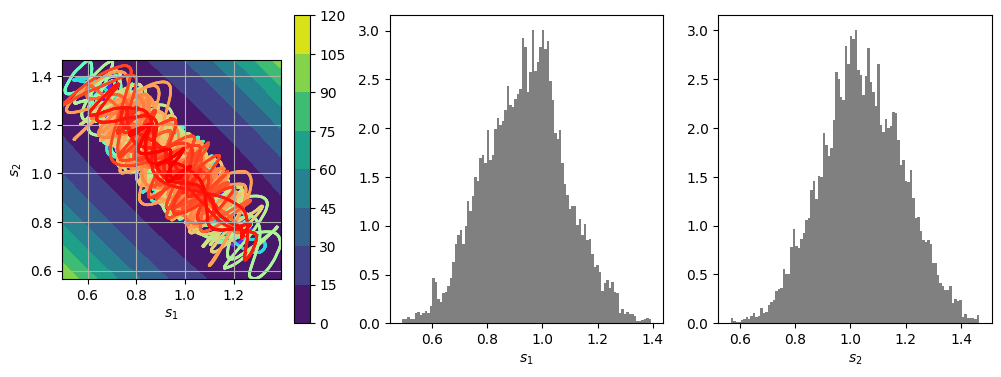

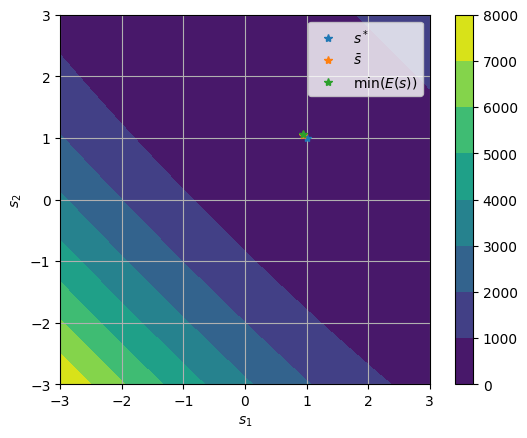

In [4]:
xlist = np.linspace(S[:,0].min(), S[:,0].max(), 100)
ylist = np.linspace(S[:,1].min(), S[:,1].max(), 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

# Z = np.zeros([Sgrid.shape[0]])
# for i in range(len(Z)):
#   Z[i] = lsc.energy(x,torch.tensor(Sgrid[i,:],dtype=torch.float))

Z = lsc.energy(x,torch.tensor(Sgrid,dtype=torch.float))

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
levels = np.asarray([1,5,10,20,40,100])
cp = axes[0].contourf(X, Y, Z.reshape(X.shape)) #,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
axes[0].scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'$s_1$')
axes[0].set_ylabel(r'$s_2$')
axes[0].grid()
# axes[0].scatter(s.detach().cpu().numpy()[0],s.detach().cpu().numpy()[1],'*',s=10)


axes[1].hist(S[:, 0], fc='grey', bins=100, density=True)
# axes[1].plot(s_, p_, 'r--')
axes[1].set_xlabel(r'$s_1$')

axes[2].hist(S[:, 1], fc='grey', bins=100, density=True)
# axes[2].plot(s_, p_, 'g--')
axes[2].set_xlabel(r'$s_2$')
# plt.suptitle(rf'$dt = {dt:.2f} M^{{-1}}$ ; $T = {TAU_SCALE} \mu^{{-1}}$')
# plt.savefig(f'{TAU_SCALE}_{DT_SCALE}.pdf')
plt.show()

# plot the energy function on a smaller scale 
vmax=3
fig,ax = plt.subplots()
xlist = np.linspace(-vmax, vmax, 100)
ylist = np.linspace(-vmax, vmax, 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

# Z = np.zeros([Sgrid.shape[0]])
# for i in range(len(Z)):
#   Z[i] = lsc.energy(x,torch.tensor(Sgrid[i,:],dtype=torch.float))

Z = lsc.energy(x,torch.tensor(Sgrid,dtype=torch.float))

cp = ax.contourf(X, Y, (Z.reshape(X.shape)))#,levels)
fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s_star.unsqueeze(0).detach().cpu().numpy().T

ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.plot(*Sgrid[(np.argmin(Z),),:].T,'*',label=r'$\min(E(s))$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
ax.legend()
ax.grid()

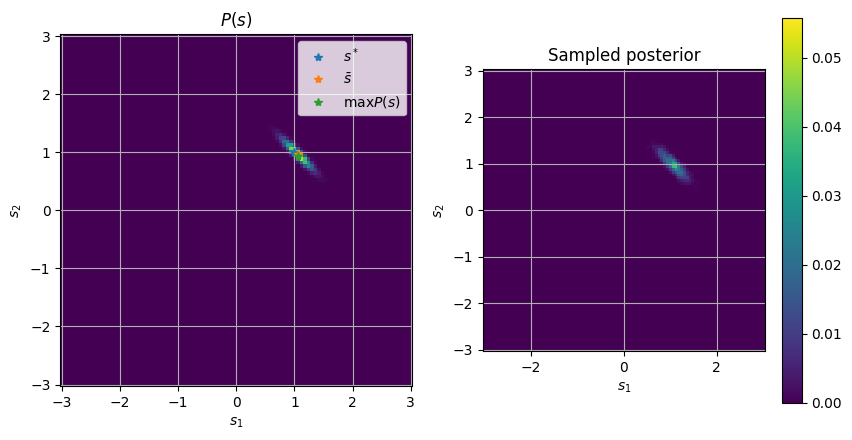

In [6]:
# plot the energy function on a smaller scale 
vmax=3
n_bins=100

fig,axs = plt.subplots(1,2,figsize=(10,5))
xlist = np.linspace(-vmax, vmax, n_bins)
ylist = np.linspace(-vmax, vmax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

# Z = np.zeros([Sgrid.shape[0]])
# for i in range(len(Z)):
#   Z[i] = lsc.p(x,torch.tensor(Sgrid[i,:],dtype=torch.float))
Z = lsc.p(x,torch.tensor(Sgrid,dtype=torch.float))
pS_energy_function = Z.reshape(X.shape).data.numpy()
pS_energy_function /= np.sum(pS_energy_function)


pS_emperical, xedges, yedges = np.histogram2d(
    x=S[:,0],
    y=S[:,1],
    bins=n_bins,
    range=[[-vmax, vmax], [-vmax, vmax]],
    density=True,
)
pS_emperical = pS_emperical.T
pS_emperical /= np.sum(pS_emperical)

vmax = np.max([pS_emperical,pS_energy_function])

ax = axs[0]
cp = ax.pcolormesh(X, Y, pS_energy_function, vmax=vmax,vmin=0)#,levels)
# fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s_star.unsqueeze(0).detach().cpu().numpy().T

ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.plot(*Sgrid[(np.argmax(Z),),:].T,'*',label=r'$\max P(s)$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
ax.legend()
ax.grid()
ax.set_title(r'$P(s)$')

ax = axs[1]
cp = ax.pcolormesh(X, Y, pS_emperical,vmax=vmax,vmin=0)
fig.colorbar(cp)
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Sampled posterior')
ax.set_aspect('equal')

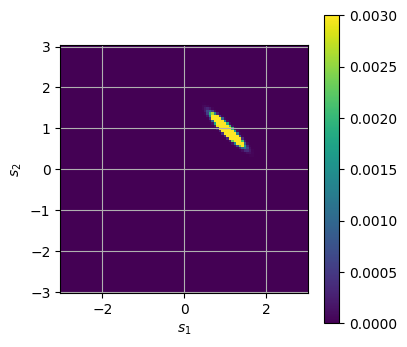

In [7]:
fig,ax = plt.subplots(figsize=(4,4))
cp = ax.pcolormesh(X, Y, pS_energy_function, vmax=3e-3,vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
cp.set_label(r'p(s)')
colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
# ax.scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()

MovieWriter ffmpeg unavailable; using Pillow instead.


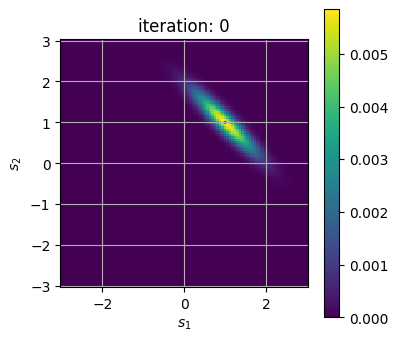

In [22]:
from matplotlib.animation import FuncAnimation 
vmax = np.max(pS_energy_function)
fig,ax = plt.subplots(figsize=(4,4))
cp = ax.pcolormesh(X, Y, pS_energy_function, vmax=vmax,vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
def animate(idx):
    ax.clear()
    cp = ax.pcolormesh(X, Y, pS_energy_function, vmax=vmax,vmin=0)#,levels)
    # fig.colorbar(cp) # Add a colorbar to a plot"
    # cp.set_label(r'p(s)')
    colors = cm.rainbow(np.linspace(0, 1, memory))
    ax.scatter(*S[idx:(idx+memory)].T, color=colors, s=1)
    # axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
    # axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
    ax.set_aspect('equal')
    ax.set_xlabel(r'$s_1$')
    ax.set_ylabel(r'$s_2$')
    ax.set_title('iteration: %d'%(idx))
    ax.grid()

interval_ms = 10
max_frames = 600
memory = 5
   
anim = FuncAnimation(fig, animate, frames = max_frames, interval = interval_ms)
   
anim.save('2nd_order_langevin_dynamics_mass=%.3f_lambda=%.3f_dt=%.1e.gif'%(mass,sparsity_penalty,dt), 
          writer = 'ffmpeg', fps = 30)

## How does KL divergence vary with sparsity penalty and momentum?


### TODO: Code below needs to be converted to batch $s$ and $x$

In [34]:
# sweep through sparsity values

sparsity_pentalty_list = np.linspace(0,6,20)
tmax = int(1e5)
vmax=3
n_bins=100

kl_values_first_order = np.empty_like(sparsity_pentalty_list)

for j in tqdm(range(len(sparsity_pentalty_list))):

    lsc.sparsity_penaly = sparsity_pentalty_list[j]

    s_inference = torch.ones_like(s_star) #Change to L0
    # s_inference = th.zeros_like(s) #Change to L0
    energies = []
    S = []
    S.append(s_inference.data.numpy().copy())
    for n in (range(tmax)):

        energies.append(lsc.energy(x,s_inference).item())
        s_inference += torch.clone(lsc.first_order_langevin_update(x,s_inference))
        S.append(s_inference.data.numpy().copy())
    S = np.asarray(S)
    energies = np.asarray(energies)

    # compute true pdf
    xlist = np.linspace(-vmax, vmax, n_bins)
    ylist = np.linspace(-vmax, vmax, n_bins)
    X, Y = np.meshgrid(xlist, ylist)
    Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

    Z = np.zeros([Sgrid.shape[0]])
    for i in range(len(Z)):
        Z[i] = lsc.p(x,torch.tensor(Sgrid[i,:],dtype=torch.float))
    pS_energy_function = Z.reshape(X.shape)
    pS_energy_function /= np.sum(pS_energy_function)

    # compute emperical pdf
    pS_emperical, xedges, yedges = np.histogram2d(
        x=S[:,0],
        y=S[:,1],
        bins=n_bins,
        range=[[-vmax, vmax], [-vmax, vmax]],
        density=True,
    )
    pS_emperical = pS_emperical.T
    pS_emperical /= np.sum(pS_emperical)

    kl_values_first_order[j] = KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten())

100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


In [37]:
# sweep through sparsity values
momentum_values = np.asarray([0.001,0.1,0.3,0.6])

# compute true pdf
xlist = np.linspace(-vmax, vmax, n_bins)
ylist = np.linspace(-vmax, vmax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
    Z[i] = lsc.p(x,torch.tensor(Sgrid[i,:],dtype=torch.float))
pS_energy_function = Z.reshape(X.shape)
pS_energy_function /= np.sum(pS_energy_function)

kl_values_second_order = np.empty([len(momentum_values),len(sparsity_pentalty_list)])
for k in tqdm(range(len(momentum_values))):
    for j in range(len(sparsity_pentalty_list)):

        lsc.sparsity_penaly = sparsity_pentalty_list[j]
        lsc.momentum = momentum_values[k]

        s_inference = torch.ones_like(s_star) #Change to L0
        v = torch.ones_like(s_star) #Change to L0
        # s_inference = th.zeros_like(s) #Change to L0
        energies = []
        S = []
        S.append(s_inference.data.numpy().copy())
        for n in (range(tmax)):

            energies.append(lsc.energy(x,s_inference).item())
            ds,dv = lsc.second_order_langevin_update(x,s_inference,v)
            s_inference += torch.clone(ds)
            v += torch.clone(dv)
            S.append(s_inference.data.numpy().copy())
        S = np.asarray(S)
        energies = np.asarray(energies)

        # compute emperical pdf
        pS_emperical, xedges, yedges = np.histogram2d(
            x=S[:,0],
            y=S[:,1],
            bins=n_bins,
            range=[[-vmax, vmax], [-vmax, vmax]],
            density=True,
        )
        pS_emperical = pS_emperical.T
        pS_emperical /= np.sum(pS_emperical)

        kl_values_second_order[k,j] = KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten())


100%|██████████| 4/4 [06:16<00:00, 94.18s/it]


Text(0.5, 1.0, '$dt=1e-02$; $T=1.0$; 1e+05 samples')

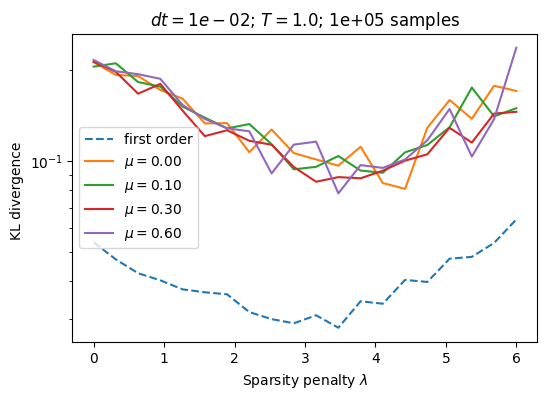

In [43]:
fig,ax = plt.subplots(figsize=(6,4))

ax.semilogy(sparsity_pentalty_list,kl_values_first_order,'--',label='first order')

for k in range(len(momentum_values)):
    ax.semilogy(sparsity_pentalty_list,kl_values_second_order[k,:],label=r'$\mu=%.2f$'%(momentum_values[k]))
ax.set_xlabel(r'Sparsity penalty $\lambda$')
ax.set_ylabel(r'KL divergence ')
ax.legend()
ax.set_title(r'$dt=%.0e$; $T=%.1f$; %.0e samples'%(dt,temperature,tmax))

## For a fixed sparsity penalty, does the second order langevin sampler converge faster? 

In [61]:
n_features = 2
n_latent = 2
sparsity_penalty = 4
temperature = 1
dt = 1e-3
mass = 1

C = lambda s: s.abs().sum()
Cprime = lambda s: torch.sign(s)

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
)

lsc.A = torch.tensor([[1., 0.], [0., 1.]])
s_star = torch.ones([n_latent,],dtype=torch.float)

NOISE_MEAN, NOISE_VARIANCE = 0 , 0.1
x = lsc.A@s_star + np.random.normal(NOISE_MEAN, NOISE_VARIANCE) # Additive Gaussian Noise

In [63]:
tmax = int(1e6)
kl_compute_iterval = 10000

# compute true pdf
xlist = np.linspace(-vmax, vmax, n_bins)
ylist = np.linspace(-vmax, vmax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
    Z[i] = lsc.p(x,torch.tensor(Sgrid[i,:],dtype=torch.float))
pS_energy_function = Z.reshape(X.shape)
pS_energy_function /= np.sum(pS_energy_function)

s_inference_fo = torch.ones_like(s_star) #Change to L0

s_inference_so = torch.ones_like(s_star) #Change to L0
v = torch.zeros_like(s_star) #Change to L0

S_fo = []
S_fo.append(s_inference_fo.data.numpy().copy())
S_so = []
S_so.append(s_inference_so.data.numpy().copy())

kl_values_fo = []
kl_values_so = []
for n in tqdm(range(tmax)):

    # first order
    s_inference_fo += torch.clone(lsc.first_order_langevin_update(x,s_inference_fo))
    S_fo.append(s_inference_fo.data.numpy().copy())

    # second order
    ds,dv = lsc.second_order_langevin_update(x,s_inference_so,v)
    s_inference_so += torch.clone(ds)
    v += torch.clone(dv)
    S_so.append(s_inference_so.data.numpy().copy())
    
    if n%kl_compute_iterval==0:
        # compute emperical pdf (first order)
        pS_emperical, xedges, yedges = np.histogram2d(
            x=np.asarray(S_fo)[:,0],
            y=np.asarray(S_fo)[:,1],
            bins=n_bins,
            range=[[-vmax, vmax], [-vmax, vmax]],
            density=True,
        )
        pS_emperical = pS_emperical.T
        pS_emperical /= np.sum(pS_emperical)
        kl_values_fo.append(KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten()))

        # compute emperical pdf (second order)
        pS_emperical, xedges, yedges = np.histogram2d(
            x=np.asarray(S_so)[:,0],
            y=np.asarray(S_so)[:,1],
            bins=n_bins,
            range=[[-vmax, vmax], [-vmax, vmax]],
            density=True,
        )
        pS_emperical = pS_emperical.T
        pS_emperical /= np.sum(pS_emperical)
        kl_values_so.append(KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten()))

S_fo = np.asarray(S_fo)
S_so = np.asarray(S_so)

100%|██████████| 1000000/1000000 [01:26<00:00, 11607.51it/s]


Text(0.5, 1.0, '$\\lambda=4$; $T=1.0$; $dt=1e-03$')

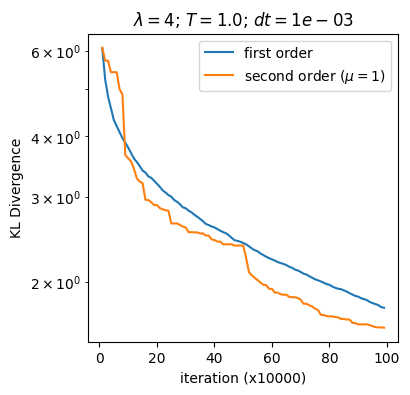

In [69]:
fig,ax = plt.subplots(figsize=(4,4))
ax.semilogy(kl_values_fo,label='first order')
ax.semilogy(kl_values_so,label=r'second order ($\mu=%.0f$)'%(lsc.mass))
ax.set_xlabel('iteration (x%d)'%(kl_compute_iterval))
ax.set_ylabel('KL Divergence')
ax.legend()
ax.set_title(r'$\lambda=%.0f$; $T=%.1f$; $dt=%.0e$'%(sparsity_penalty,temperature,dt))

It is difficult to choose an appropriate step size, due to the lack of smoothness in the energy function

## Validate that sampling is working correctly 
* Generate dataset with factorial latent structure
* Infer latent structure
* Verify that the inferred latent structure is the same as the true structure
    * will use independance as a statistic to validate this

In [91]:
n_features = 2
n_latent = 2
sparsity_penalty = 1.
var = 1/sparsity_penalty
temperature = 1
dt = 5e-4
mass = 1
NOISE_MEAN, NOISE_STD = 0 , 0.1

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD,
)

lsc.A = torch.tensor([[1., 1.], [1., -0.1]])
# lsc.A = torch.tensor([[1., 0.], [0., 1.]])

In [92]:
n_samples = int(1e4)
distribution = torch.distributions.Laplace(0.0, var)
s_star = distribution.sample(sample_shape=[n_samples,n_latent])

In [93]:
tmax = int(1e4)

x = (lsc.A@s_star.T).T + np.random.normal(NOISE_MEAN,NOISE_STD)

s_inference = torch.zeros_like(s_star) #Change to L0
v = torch.zeros_like(s_star) #Change to L0
S = []
for n in tqdm(range(tmax)):
    ds,dv = lsc.second_order_langevin_update(x,s_inference,v)
    s_inference += torch.clone(ds)
    v += torch.clone(dv)
    S.append(s_inference.data.numpy().copy())
S = np.asarray(S)

100%|██████████| 10000/10000 [00:03<00:00, 2701.79it/s]


In [94]:
smax = 3
xlist = np.linspace(-smax, smax, n_bins)
ylist = np.linspace(-smax, smax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
all_dists = np.empty([n_samples,n_bins,n_bins])

for i in tqdm(range(n_samples)):
    # compute emperical pdf (second order)
    pS_emperical, xedges, yedges = np.histogram2d(
        x=S[:,i,0],
        y=S[:,i,1],
        bins=n_bins,
        range=[[-smax, smax], [-smax, smax]],
        density=True,
    )
    pS_emperical = pS_emperical.T
    pS_emperical /= np.sum(pS_emperical)
    all_dists[i,:,:] = pS_emperical


# compute emperical pdf (second order)
pS_true, xedges, yedges = np.histogram2d(
    x=s_star[:,0].detach().numpy(),
    y=s_star[:,1].detach().numpy(),
    bins=n_bins,
    range=[[-smax, smax], [-smax, smax]],
    density=True,
)
pS_true = pS_true.T
pS_true /= np.sum(pS_true)

100%|██████████| 10000/10000 [00:12<00:00, 810.89it/s]


Text(0.5, 1.0, 'Sampled prior')

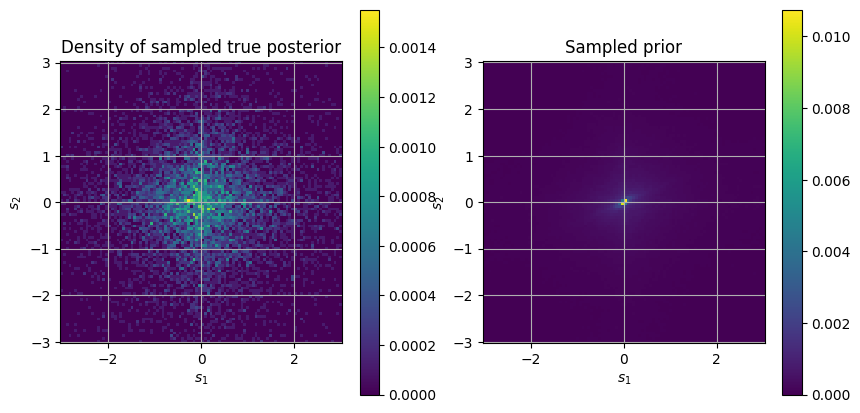

In [95]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
cp = ax.pcolormesh(X, Y, pS_true, vmax=pS_true.max(),vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
cp.set_label(r'p(s)')
# colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
# ax.scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title('Density of sampled true posterior')

ax = axs[1]
cp = ax.pcolormesh(X, Y, np.mean(all_dists,axis=0), vmax=np.mean(all_dists,axis=0).max(),vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
cp.set_label(r'p(s)')
# colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
# ax.scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title('Sampled prior')

Text(0.5, 1.0, 'Sampled posterior')

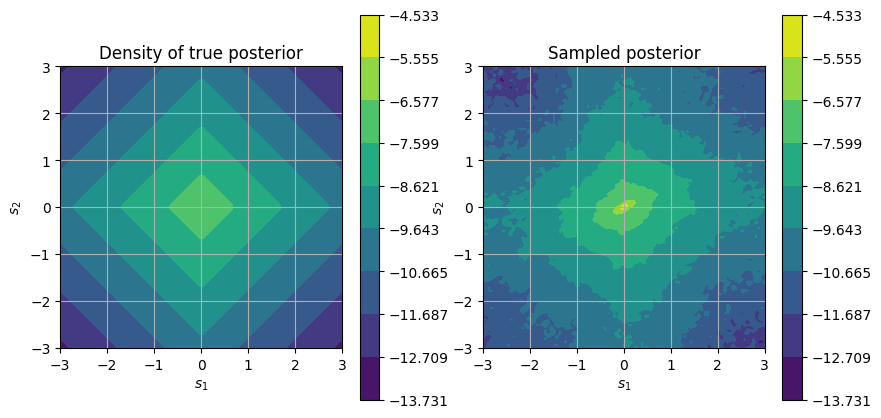

In [96]:
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T
# Sgrid = np.asarray([X.flatten()]).T
# pS_true_ = 0.5/var*np.exp(-np.abs(Sgrid)/var).sum(axis=1)
pS_true_ = np.exp(distribution.log_prob(torch.tensor(Sgrid)).data.numpy().sum(axis=1))
pS_true_ /= np.sum(pS_true_)

emp_dens = np.mean(all_dists,axis=0)
emp_dens /= np.sum(emp_dens)
line_min = np.log(np.min([emp_dens.flatten(),pS_true_.flatten()]))
line_max = np.log(np.max([emp_dens.flatten(),pS_true_.flatten()]))
lines = np.linspace(line_min,line_max,10)

fig,axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
cp = ax.contourf(X, Y, np.log(pS_true_.reshape(X.shape)),lines)#, vmax=pS_true_.max(),vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
# cp.set_label(r'p(s)')
# colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
# ax.scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title('Density of true posterior')

ax = axs[1]
cp = ax.contourf(X, Y, np.log(emp_dens),lines)#, vmax=np.mean(all_dists,axis=0).max(),vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
# cp.set_label(r'p(s)')
# colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
# ax.scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
ax.set_aspect('equal')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title('Sampled posterior')

## Woo! 
* The latent data was generated according to above distribution 
* in expectation, the inferred latent data also appears to be same distribution
* This says the sampler is working correctly!

## What next? 
* ~~get noise term correct~~ 
    * If noise term is really small in comparison to sparsity, $dt$ must be decreased (posterior highly peaked)
    * in general, if posterior is highly peaked, $dt$ must be small
* ~~verify sampling works with different dictionaries~~
* Dictionary learning
* Does second order sample faster than first order? 
    * How to quantify this emperically?
    * how many samples do you need? 
    * Burn-in period?
    * How does this scale with dimensionality?
        * literature on this? 
* Sample from the spike and slab prior?
* characterize/tune hyperparameters
    * vary number of samples
    * time step
    * interations
    * compare first order and second order 
        * Compute KL divergance? only will work for 2D case rn
        * Learning the correct dictionary
        * look at moments of posterior 
* compare sampling to just doing map estimates
* Implications of second order sampling and sparse coding
    * Not necessarily learning the dictionary/latent factors but instead leverage sparse coding and langevin sampling to make neuroscientific statements

## Directions
* bayesian inference and dictionary in noise dominated regime 

/var/folders/hy/7cxjc3qx1vsfk45ckcv7_w3h0000gn/T/ipykernel_67604/541123794.py:18: RuntimeWarning: divide by zero encountered in log
  cp = ax.pcolormesh(X, Y, np.log(pS_energy_function))#,vmin=0)#,levels)
/var/folders/hy/7cxjc3qx1vsfk45ckcv7_w3h0000gn/T/ipykernel_67604/541123794.py:35: RuntimeWarning: divide by zero encountered in log
  cp = ax.pcolormesh(X, Y, np.log(all_dists[ind,:,:]))#, vmax=all_dists[ind,:,:].max(),vmin=0)#,levels)


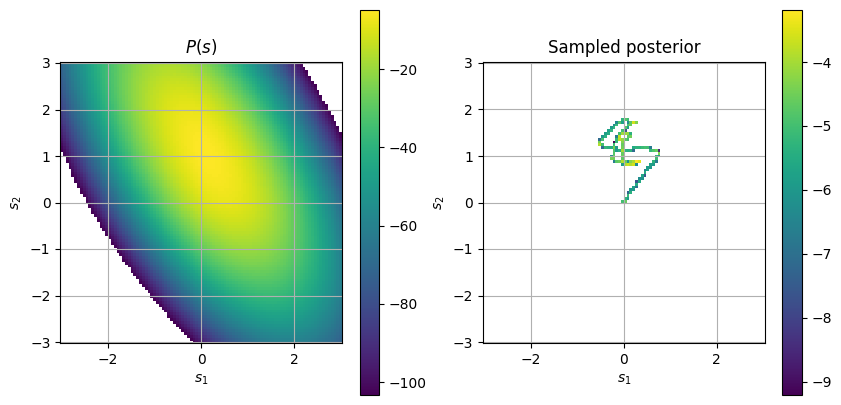

In [97]:
ind = 1

# plot the energy function on a smaller scale 
vmax=3
n_bins=100

fig,axs = plt.subplots(1,2,figsize=(10,5))
xlist = np.linspace(-vmax, vmax, n_bins)
ylist = np.linspace(-vmax, vmax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = lsc.p(x[(ind,),:],torch.tensor(Sgrid,dtype=torch.float))
pS_energy_function = Z.reshape(X.shape).data.numpy()
pS_energy_function /= np.sum(pS_energy_function)

ax = axs[0]
cp = ax.pcolormesh(X, Y, np.log(pS_energy_function))#,vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s_star.unsqueeze(0).detach().cpu().numpy().T

# ax.plot(*q,'*',label=r'$s^*$')
# ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
# ax.plot(*Sgrid[(np.argmax(Z),),:].T,'*',label=r'$\max P(s)$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
# ax.legend()
ax.grid()
ax.set_title(r'$P(s)$')

ax = axs[1]
cp = ax.pcolormesh(X, Y, np.log(all_dists[ind,:,:]))#, vmax=all_dists[ind,:,:].max(),vmin=0)#,levels)
fig.colorbar(cp)
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Sampled posterior')
ax.set_aspect('equal')
